In [2]:
import numpy as np
import pandas as pd
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_score, GroupKFold, StratifiedGroupKFold
import shap
import gpplot as gpp
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import gpplot
from rs3.seq import predict_seq
import optuna
from optuna.integration import LightGBMPruningCallback
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
import warnings
from core import tssbin_binary
import sglearn
from lightgbm import LGBMRegressor, plot_importance
from core1 import (setup_plots,
                  lollipop_plot,
                  get_feature_df,
                  summary_legacy,
                  dependence_legacy)
import warnings
warnings.filterwarnings('ignore')
#warnings.filterwarnings("ignore", category=UserWarning)
#optuna.logging.set_verbosity(optuna.logging.WARNING)


Todo
- DHS
- each nuetitde as a single nts only
- gilbert et al: top 5 features, look at easy feature


In [3]:
#Function
def obs_vals_vs_scores(dataset, list_obs_vals, list_scores, author='Gilbert', obs_meteric = 'Gamma'):
    for obs_v, score in zip(list_obs_vals, list_scores):
            plt.subplots(figsize=(4,4))
            gpp.point_densityplot(data=dataset[[score, obs_v]].dropna(),
                                     y=score, x=obs_v)
            gpp.add_correlation(data=dataset[[score, obs_v]].dropna(),
                                   y=score, x=obs_v)
            gpp.add_correlation(data=dataset[[score, obs_v]].dropna(),
                                    y=score, x=obs_v, method='spearman', loc='lower right')
           # plt.xlabel(x_axis_name)
            plt.title(author+" Crispri")
            plt.xlabel(obs_meteric)
           
            sns.despine()
            gpp.savefig('../figure/nts/'+ score +'_vs_'+obs_meteric+'_'+author+'.pdf', dpi=300)
def tss_plot(dataset, y_axis, dataname='gilbert'):
    x_orders = ['<-50','-50 to -25','-25 to 0','0 to +25', '+25 to +50','+50 to +75','+75 to +100',
                            '+100 to +125','+125 to +150','+150 to +175', '+175 to +200', '+200 to +225',
                             '+225 to +250','>+250']
    fig, axs = plt.subplots(nrows=len(y_axis),figsize=(7,6))
    for i in range(len(y_axis)):
        ax = sns.boxplot(data=dataset, x="tss_bins", y=y_axis[i], 
                   order = x_orders, color = 'grey', ax = axs[i])
        if i != len(y_axis)-1:
            ax.set(xticklabels=[])  
            ax.set(xlabel=None)
            ax.tick_params(bottom=False)
        else:
            ax.set(xlabel='TSS Bins')
            plt.xticks(rotation=90)
    
    gpp.savefig('../figure/nts/'+ dataname +'_tss_box_plot.pdf', dpi=300)
def corr_pval_table(dataset, metric):
    tss_bins_cat = ['<-50','-50 to -25','-25 to 0','0 to +25', '+25 to +50','+50 to +75','+75 to +100',
                        '+100 to +125','+125 to +150','+150 to +175', '+175 to +200', '+200 to +225',
                         '+225 to +250','>+250']
    data_performance = pd.DataFrame()
    for bins in tss_bins_cat:
        bin_sub = dataset[dataset['tss_bins'] == bins]
        corr_rs3, p_corr_rs3 = stats.spearmanr(bin_sub['Chen On-Target Efficacy Score'], bin_sub[str('avg_' + metric)])
        #corr_target, p_corr_target = stats.spearmanr(bin_sub['Crispri Seq + Target Score'], bin_sub['reverse ' + metric])
        corr_target, p_corr_target = stats.spearmanr(bin_sub['Crispri Seq + Target Score'], bin_sub['avg_' + metric])

        data_performance = data_performance.append({'bin':bins,
                                          'corr_rs3': corr_rs3, 
                                          'p_val_corr_rs3': p_corr_rs3,
                                          'corr_seq_target': corr_target,
                                         'p_val_corr_seq_target': p_corr_target}, ignore_index=True)
    return data_performance

# Train model

### Import Gilbert to train 

In [4]:
gilbert2014_rs3 = pd.read_csv('../data/gilbert_2014/gilbert2014_activity.csv')
gilbert2014_rs3 = gilbert2014_rs3.rename({'On-Target Efficacy Score': 'Chen On-Target Efficacy Score'},axis = 1)
#all_designs = pd.read_table('../../../gpp-annotation-files/sgRNA_design_9606_GRCh38_SpyoCas9_CRISPRi_RS3seq-Chen2013_Ensembl_20220808.txt.gz')


In [46]:
all_designs = pd.read_table('../../../gpp-annotation-files/sgRNA_design_9606_GRCh38_SpyoCas9_CRISPRi_RS3seq-Chen2013_Ensembl_20220808.txt.gz')


In [48]:
all_designs.columns

Index(['Input', 'Quota', 'Target Taxon', 'Target Gene ID',
       'Target Gene Symbol', 'Target Alias', 'CRISPR Mechanism',
       'Target Domain', 'Reference Sequence', 'Strand of Target',
       'TSS Position', 'PAM Policy', 'Off-Target Match Ruleset Version',
       'Off-Target Tier Policy', 'Off-Target Match Bin Policy',
       'Strand of sgRNA', 'Orientation', 'sgRNA 'Cut' Position',
       'sgRNA Sequence', 'sgRNA Context Sequence', 'PAM Sequence',
       'sgRNA 'Cut' Site TSS Offset', 'Other Target Matches',
       '# Off-Target Tier I Match Bin I Matches',
       '# Off-Target Tier II Match Bin I Matches',
       '# Off-Target Tier III Match Bin I Matches',
       '# Off-Target Tier I Match Bin II Matches',
       '# Off-Target Tier II Match Bin II Matches',
       '# Off-Target Tier III Match Bin II Matches',
       '# Off-Target Tier I Match Bin III Matches',
       '# Off-Target Tier II Match Bin III Matches',
       '# Off-Target Tier III Match Bin III Matches',
       '# O

In [5]:
gilbert2014_rs3.columns

Index(['sgRNA Sequence', 'sgRNA Context Sequence', 'Target Gene Symbol',
       'Chen On-Target Efficacy Score', 'sgRNA 'Cut' Site TSS Offset',
       'DHS Score', 'Off-Target Rank', 'Pick Order', 'avg_rank',
       'avg_mean_centered_neg_gamma', 'avg_zscore_neg_gamma',
       'avg_median_centered_neg_gamma', 'avg_robust_zscore_neg_gamma',
       'avg_gamma'],
      dtype='object')

In [6]:
gilbert2014_rs3 = gilbert2014_rs3[['sgRNA Context Sequence', 'sgRNA Sequence', 
                 'Target Gene Symbol', 'Chen On-Target Efficacy Score',
                'sgRNA \'Cut\' Site TSS Offset', 'avg_gamma', 'avg_mean_centered_neg_gamma','DHS Score']]
gilbert2014_rs3 = tssbin_binary(gilbert2014_rs3)

In [7]:
tss_bins_col_name = [col for col in gilbert2014_rs3.columns if col.startswith('tss_bins_')]
x_variable = ['sgRNA \'Cut\' Site TSS Offset', 'sgRNA Context Sequence','Chen On-Target Efficacy Score'] + tss_bins_col_name


### Define X and Y and group in gilbert 

In [8]:
X = gilbert2014_rs3[x_variable]

In [9]:
seq_feature = sglearn.featurize_guides(X['sgRNA Context Sequence'])

100%|████████████████████████████████████| 10601/10601 [00:31<00:00, 337.90it/s]


In [10]:
seq_feature = seq_feature.reset_index()
nts_feature = seq_feature[['sgRNA Context Sequence',  '-4A', '-4C', '-4T', '-4G', '-3A', '-3C', '-3T', '-3G', '-2A',
       '-2C', '-2T', '-2G', '-1A', '-1C', '-1T', '-1G','1A', '1C', '1T', '1G', '2A', '2C', '2T', '2G', '3A', '3C', '3T', '3G', '4A', '4C',
       '4T', '4G', '5A', '5C', '5T', '5G', '6A', '6C', '6T', '6G', '7A',
       '7C', '7T', '7G', '8A', '8C', '8T', '8G', '9A', '9C', '9T', '9G',
       '10A', '10C', '10T', '10G', '11A', '11C', '11T', '11G', '12A',
       '12C', '12T', '12G', '13A', '13C', '13T', '13G', '14A', '14C',
       '14T', '14G', '15A', '15C', '15T', '15G', '16A', '16C', '16T',
       '16G', '17A', '17C', '17T', '17G', '18A', '18C', '18T', '18G',
       '19A', '19C', '19T', '19G', '20A', '20C', '20T', '20G']]


In [11]:
X = pd.merge(X, nts_feature, on = 'sgRNA Context Sequence')

In [12]:
X = X.set_index('sgRNA Context Sequence')    
y = gilbert2014_rs3['avg_gamma'] * -1
grps = gilbert2014_rs3['Target Gene Symbol']


### Define objective to train the model on Gilbert

In [13]:
def objective(trial, X, y, groups, cv=4 ):
    param_grid = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1500),
        "learning_rate": trial.suggest_categorical("learning_rate", [0.01,0.02,0.03,0.04, 0.05]),
        "num_leaves": trial.suggest_int('num_leaves', 8, 256),
        "min_child_samples": trial.suggest_int('min_child_samples', 50, 256)

    }

    cv_scores = np.zeros(cv)
    
    #gkf_cv = GroupKFold(n_splits=3)
    gkf_cv = StratifiedGroupKFold(n_splits=cv, shuffle=True, random_state=1)
    df_group = pd.DataFrame()


    for split, (ix_train, ix_test) in enumerate(gkf_cv.split(X,[1]*grps, groups=groups)):
        X_train, X_test, y_train, y_test = X.iloc[ix_train], X.iloc[ix_test], y.iloc[ix_train], y.iloc[ix_test]

        model = LGBMRegressor(random_state=7, n_jobs=1, **param_grid)
        df_group = df_group.append({'fold': split, 'num_train_gene': len(set(grps[ix_train].tolist())),
                    'num_train_sgrna': len(grps[ix_train].tolist()), 
                    'num_test_gene': len(set(grps[ix_test].tolist())),
                   'num_test_sgRNA': len(grps[ix_test].tolist()),
                   'num_overlap_gene': len(list(set(grps[ix_train]) & set(grps[ix_test])))}, ignore_index=True)
        print(df_group)
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_test, y_test)],
            eval_metric="l2",
            verbose=-1,
             early_stopping_rounds=50,)
        preds = model.score(X_train, y_train)
        
        cv_scores[split] = preds


    return 1-np.mean(cv_scores)

In [14]:
study = optuna.create_study(direction="minimize", study_name="LGBM Regressor")

def func(trial):
    return objective(trial, X, y, grps)

study.optimize(func, n_trials=50);

[I 2022-11-10 03:25:06,403] A new study created in memory with name: LGBM Regressor


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[240]	valid_0's l2: 0.0114955
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[299]	valid_0's l2: 0.011701
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             7

[I 2022-11-10 03:25:09,350] Trial 0 finished with value: 0.7214674249051938 and parameters: {'n_estimators': 661, 'learning_rate': 0.02, 'num_leaves': 247, 'min_child_samples': 219}. Best is trial 0 with value: 0.7214674249051938.


Early stopping, best iteration is:
[289]	valid_0's l2: 0.011967
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[241]	valid_0's l2: 0.0114999
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[273]	valid_0's l2: 0.011727
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899        

[I 2022-11-10 03:25:12,288] Trial 1 finished with value: 0.7220415585037167 and parameters: {'n_estimators': 806, 'learning_rate': 0.02, 'num_leaves': 164, 'min_child_samples': 215}. Best is trial 0 with value: 0.7214674249051938.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[179]	valid_0's l2: 0.0115128
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[183]	valid_0's l2: 0.0117444
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2   

[I 2022-11-10 03:25:14,424] Trial 2 finished with value: 0.7560436388207838 and parameters: {'n_estimators': 184, 'learning_rate': 0.02, 'num_leaves': 79, 'min_child_samples': 213}. Best is trial 0 with value: 0.7214674249051938.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[63]	valid_0's l2: 0.0114841
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[82]	valid_0's l2: 0.0117061
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             79

[I 2022-11-10 03:25:16,240] Trial 3 finished with value: 0.7162701284482086 and parameters: {'n_estimators': 884, 'learning_rate': 0.05, 'num_leaves': 162, 'min_child_samples': 175}. Best is trial 3 with value: 0.7162701284482086.


Early stopping, best iteration is:
[101]	valid_0's l2: 0.0119847
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[48]	valid_0's l2: 0.0115233
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[84]	valid_0's l2: 0.0117942
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899        

[I 2022-11-10 03:25:18,374] Trial 4 finished with value: 0.6484530743556983 and parameters: {'n_estimators': 904, 'learning_rate': 0.04, 'num_leaves': 228, 'min_child_samples': 78}. Best is trial 4 with value: 0.6484530743556983.


Early stopping, best iteration is:
[117]	valid_0's l2: 0.011993
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[81]	valid_0's l2: 0.011589
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[61]	valid_0's l2: 0.0118149
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899          

[I 2022-11-10 03:25:20,629] Trial 5 finished with value: 0.5993855981292373 and parameters: {'n_estimators': 1387, 'learning_rate': 0.04, 'num_leaves': 180, 'min_child_samples': 54}. Best is trial 5 with value: 0.5993855981292373.


Early stopping, best iteration is:
[72]	valid_0's l2: 0.0120293
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[267]	valid_0's l2: 0.0114998
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[295]	valid_0's l2: 0.0116808
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899       

[I 2022-11-10 03:25:23,513] Trial 6 finished with value: 0.7152533422896724 and parameters: {'n_estimators': 975, 'learning_rate': 0.02, 'num_leaves': 149, 'min_child_samples': 231}. Best is trial 5 with value: 0.5993855981292373.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[115]	valid_0's l2: 0.0115396
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[142]	valid_0's l2: 0.0117304
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             

[I 2022-11-10 03:25:25,796] Trial 7 finished with value: 0.6468904013566326 and parameters: {'n_estimators': 929, 'learning_rate': 0.03, 'num_leaves': 145, 'min_child_samples': 95}. Best is trial 5 with value: 0.5993855981292373.


Early stopping, best iteration is:
[159]	valid_0's l2: 0.0120237
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[169]	valid_0's l2: 0.0115518
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[169]	valid_0's l2: 0.0118521
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             

[I 2022-11-10 03:25:27,870] Trial 8 finished with value: 0.773853778294272 and parameters: {'n_estimators': 169, 'learning_rate': 0.01, 'num_leaves': 73, 'min_child_samples': 111}. Best is trial 5 with value: 0.5993855981292373.


Did not meet early stopping. Best iteration is:
[169]	valid_0's l2: 0.0121583
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[266]	valid_0's l2: 0.011473
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[276]	valid_0's l2: 0.0116957
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945           

[I 2022-11-10 03:25:30,625] Trial 9 finished with value: 0.7167549465936196 and parameters: {'n_estimators': 989, 'learning_rate': 0.02, 'num_leaves': 246, 'min_child_samples': 220}. Best is trial 5 with value: 0.5993855981292373.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[92]	valid_0's l2: 0.0115282
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[190]	valid_0's l2: 0.0117281
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             7

[I 2022-11-10 03:25:32,208] Trial 10 finished with value: 0.685824637382614 and parameters: {'n_estimators': 1490, 'learning_rate': 0.04, 'num_leaves': 20, 'min_child_samples': 57}. Best is trial 5 with value: 0.5993855981292373.


Early stopping, best iteration is:
[140]	valid_0's l2: 0.012025
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[73]	valid_0's l2: 0.0115083
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[164]	valid_0's l2: 0.011676
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899         

[I 2022-11-10 03:25:34,353] Trial 11 finished with value: 0.6698264307333346 and parameters: {'n_estimators': 1431, 'learning_rate': 0.03, 'num_leaves': 192, 'min_child_samples': 110}. Best is trial 5 with value: 0.5993855981292373.


Early stopping, best iteration is:
[178]	valid_0's l2: 0.0119856
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[73]	valid_0's l2: 0.0115054
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[148]	valid_0's l2: 0.0117271
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899       

[I 2022-11-10 03:25:36,604] Trial 12 finished with value: 0.666265661583336 and parameters: {'n_estimators': 1205, 'learning_rate': 0.03, 'num_leaves': 107, 'min_child_samples': 97}. Best is trial 5 with value: 0.5993855981292373.


Early stopping, best iteration is:
[154]	valid_0's l2: 0.012011
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[54]	valid_0's l2: 0.0115809
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[90]	valid_0's l2: 0.0118752
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899         

[I 2022-11-10 03:25:38,922] Trial 13 finished with value: 0.6226602364820539 and parameters: {'n_estimators': 486, 'learning_rate': 0.03, 'num_leaves': 196, 'min_child_samples': 50}. Best is trial 5 with value: 0.5993855981292373.


Early stopping, best iteration is:
[95]	valid_0's l2: 0.012045
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[50]	valid_0's l2: 0.0115389
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[63]	valid_0's l2: 0.0118482
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899          

[I 2022-11-10 03:25:40,946] Trial 14 finished with value: 0.6099465480990421 and parameters: {'n_estimators': 494, 'learning_rate': 0.04, 'num_leaves': 203, 'min_child_samples': 51}. Best is trial 5 with value: 0.5993855981292373.


Early stopping, best iteration is:
[72]	valid_0's l2: 0.01205
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[89]	valid_0's l2: 0.0115111
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[119]	valid_0's l2: 0.0117039
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899          

[I 2022-11-10 03:25:42,892] Trial 15 finished with value: 0.6960103117686038 and parameters: {'n_estimators': 457, 'learning_rate': 0.04, 'num_leaves': 202, 'min_child_samples': 143}. Best is trial 5 with value: 0.5993855981292373.


Early stopping, best iteration is:
[123]	valid_0's l2: 0.0119258
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[69]	valid_0's l2: 0.0114986
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[110]	valid_0's l2: 0.0116666
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899       

[I 2022-11-10 03:25:44,982] Trial 16 finished with value: 0.6846907954272432 and parameters: {'n_estimators': 1245, 'learning_rate': 0.04, 'num_leaves': 115, 'min_child_samples': 133}. Best is trial 5 with value: 0.5993855981292373.


Early stopping, best iteration is:
[150]	valid_0's l2: 0.0119384
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[107]	valid_0's l2: 0.0115089
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[137]	valid_0's l2: 0.0117185
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899      

[I 2022-11-10 03:25:46,960] Trial 17 finished with value: 0.698490062662702 and parameters: {'n_estimators': 593, 'learning_rate': 0.04, 'num_leaves': 184, 'min_child_samples': 177}. Best is trial 5 with value: 0.5993855981292373.


Early stopping, best iteration is:
[159]	valid_0's l2: 0.0119888
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[219]	valid_0's l2: 0.0115104
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[263]	valid_0's l2: 0.0117721
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899      

[I 2022-11-10 03:25:51,026] Trial 18 finished with value: 0.6698603651813966 and parameters: {'n_estimators': 352, 'learning_rate': 0.01, 'num_leaves': 229, 'min_child_samples': 74}. Best is trial 5 with value: 0.5993855981292373.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	valid_0's l2: 0.0114835
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[70]	valid_0's l2: 0.0118281
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             79

[I 2022-11-10 03:25:52,815] Trial 19 finished with value: 0.6421540178809423 and parameters: {'n_estimators': 1146, 'learning_rate': 0.05, 'num_leaves': 219, 'min_child_samples': 78}. Best is trial 5 with value: 0.5993855981292373.


Early stopping, best iteration is:
[83]	valid_0's l2: 0.0120157
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[66]	valid_0's l2: 0.0115122
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[97]	valid_0's l2: 0.0117228
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899         

[I 2022-11-10 03:25:54,592] Trial 20 finished with value: 0.688140701801442 and parameters: {'n_estimators': 663, 'learning_rate': 0.04, 'num_leaves': 124, 'min_child_samples': 121}. Best is trial 5 with value: 0.5993855981292373.


Early stopping, best iteration is:
[123]	valid_0's l2: 0.011906
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[65]	valid_0's l2: 0.0115756
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[91]	valid_0's l2: 0.0118318
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899         

[I 2022-11-10 03:25:56,953] Trial 21 finished with value: 0.5970567106550213 and parameters: {'n_estimators': 398, 'learning_rate': 0.03, 'num_leaves': 176, 'min_child_samples': 53}. Best is trial 21 with value: 0.5970567106550213.


Early stopping, best iteration is:
[117]	valid_0's l2: 0.0120635
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[42]	valid_0's l2: 0.0115682
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[69]	valid_0's l2: 0.0117922
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899        

[I 2022-11-10 03:25:58,928] Trial 22 finished with value: 0.6298759445227211 and parameters: {'n_estimators': 381, 'learning_rate': 0.04, 'num_leaves': 173, 'min_child_samples': 61}. Best is trial 21 with value: 0.5970567106550213.


Early stopping, best iteration is:
[103]	valid_0's l2: 0.0119375
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[81]	valid_0's l2: 0.0115035
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[134]	valid_0's l2: 0.011791
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899        

[I 2022-11-10 03:26:01,289] Trial 23 finished with value: 0.6350128086068441 and parameters: {'n_estimators': 287, 'learning_rate': 0.03, 'num_leaves': 214, 'min_child_samples': 70}. Best is trial 21 with value: 0.5970567106550213.


Early stopping, best iteration is:
[101]	valid_0's l2: 0.0120271
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[55]	valid_0's l2: 0.0114874
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[95]	valid_0's l2: 0.0116756
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899        

[I 2022-11-10 03:26:03,196] Trial 24 finished with value: 0.6454858304706956 and parameters: {'n_estimators': 588, 'learning_rate': 0.04, 'num_leaves': 143, 'min_child_samples': 89}. Best is trial 21 with value: 0.5970567106550213.


Early stopping, best iteration is:
[154]	valid_0's l2: 0.0119674
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[29]	valid_0's l2: 0.011606
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[76]	valid_0's l2: 0.0118779
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             

[I 2022-11-10 03:26:05,038] Trial 25 finished with value: 0.5757566867770849 and parameters: {'n_estimators': 108, 'learning_rate': 0.05, 'num_leaves': 184, 'min_child_samples': 50}. Best is trial 25 with value: 0.5757566867770849.


Did not meet early stopping. Best iteration is:
[69]	valid_0's l2: 0.0121206
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[97]	valid_0's l2: 0.0115393
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[99]	valid_0's l2: 0.0116876
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             

[I 2022-11-10 03:26:06,658] Trial 26 finished with value: 0.7323948904741668 and parameters: {'n_estimators': 155, 'learning_rate': 0.05, 'num_leaves': 171, 'min_child_samples': 256}. Best is trial 25 with value: 0.5757566867770849.


Did not meet early stopping. Best iteration is:
[128]	valid_0's l2: 0.0119329
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[46]	valid_0's l2: 0.0115321
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[105]	valid_0's l2: 0.0117029
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945           

[I 2022-11-10 03:26:08,364] Trial 27 finished with value: 0.7064465036909044 and parameters: {'n_estimators': 264, 'learning_rate': 0.05, 'num_leaves': 97, 'min_child_samples': 165}. Best is trial 25 with value: 0.5757566867770849.


Early stopping, best iteration is:
[136]	valid_0's l2: 0.0118985
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[34]	valid_0's l2: 0.0115498
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[58]	valid_0's l2: 0.0118329
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899        

[I 2022-11-10 03:26:10,043] Trial 28 finished with value: 0.6359182184140774 and parameters: {'n_estimators': 108, 'learning_rate': 0.05, 'num_leaves': 182, 'min_child_samples': 65}. Best is trial 25 with value: 0.5757566867770849.


Did not meet early stopping. Best iteration is:
[77]	valid_0's l2: 0.011999
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[187]	valid_0's l2: 0.0115056
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[331]	valid_0's l2: 0.0117606
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945            

[I 2022-11-10 03:26:14,799] Trial 29 finished with value: 0.651951568428112 and parameters: {'n_estimators': 690, 'learning_rate': 0.01, 'num_leaves': 254, 'min_child_samples': 80}. Best is trial 25 with value: 0.5757566867770849.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[98]	valid_0's l2: 0.0115137
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[108]	valid_0's l2: 0.0117276
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             7

[I 2022-11-10 03:26:16,944] Trial 30 finished with value: 0.6538930341326011 and parameters: {'n_estimators': 1345, 'learning_rate': 0.03, 'num_leaves': 129, 'min_child_samples': 90}. Best is trial 25 with value: 0.5757566867770849.


Early stopping, best iteration is:
[160]	valid_0's l2: 0.0119986
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[38]	valid_0's l2: 0.0115378
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[47]	valid_0's l2: 0.0118853
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899        

[I 2022-11-10 03:26:18,741] Trial 31 finished with value: 0.6185584335059641 and parameters: {'n_estimators': 511, 'learning_rate': 0.05, 'num_leaves': 207, 'min_child_samples': 60}. Best is trial 25 with value: 0.5757566867770849.


Early stopping, best iteration is:
[88]	valid_0's l2: 0.0119884
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[42]	valid_0's l2: 0.0115941
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[88]	valid_0's l2: 0.0118014
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899         

[I 2022-11-10 03:26:20,858] Trial 32 finished with value: 0.5748682799097227 and parameters: {'n_estimators': 728, 'learning_rate': 0.04, 'num_leaves': 157, 'min_child_samples': 50}. Best is trial 32 with value: 0.5748682799097227.


Early stopping, best iteration is:
[109]	valid_0's l2: 0.0119961
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[64]	valid_0's l2: 0.0115478
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[101]	valid_0's l2: 0.0118353
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899       

[I 2022-11-10 03:26:22,833] Trial 33 finished with value: 0.6097644945281745 and parameters: {'n_estimators': 761, 'learning_rate': 0.04, 'num_leaves': 157, 'min_child_samples': 66}. Best is trial 32 with value: 0.5748682799097227.


Early stopping, best iteration is:
[90]	valid_0's l2: 0.012009
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[29]	valid_0's l2: 0.011606
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[76]	valid_0's l2: 0.0118779
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899           

[I 2022-11-10 03:26:24,769] Trial 34 finished with value: 0.5757566867770849 and parameters: {'n_estimators': 1073, 'learning_rate': 0.05, 'num_leaves': 174, 'min_child_samples': 50}. Best is trial 32 with value: 0.5748682799097227.


Early stopping, best iteration is:
[69]	valid_0's l2: 0.0121206
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[29]	valid_0's l2: 0.011606
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[76]	valid_0's l2: 0.0118779
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899          

[I 2022-11-10 03:26:26,702] Trial 35 finished with value: 0.5757566867770849 and parameters: {'n_estimators': 1120, 'learning_rate': 0.05, 'num_leaves': 165, 'min_child_samples': 50}. Best is trial 32 with value: 0.5748682799097227.


Early stopping, best iteration is:
[69]	valid_0's l2: 0.0121206
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[35]	valid_0's l2: 0.0115216
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[63]	valid_0's l2: 0.0117769
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899         

[I 2022-11-10 03:26:28,273] Trial 36 finished with value: 0.6831648879743009 and parameters: {'n_estimators': 1101, 'learning_rate': 0.05, 'num_leaves': 160, 'min_child_samples': 84}. Best is trial 32 with value: 0.5748682799097227.


Early stopping, best iteration is:
[75]	valid_0's l2: 0.0120257
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[47]	valid_0's l2: 0.0115182
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[90]	valid_0's l2: 0.011745
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899          

[I 2022-11-10 03:26:29,963] Trial 37 finished with value: 0.6583450972550827 and parameters: {'n_estimators': 1066, 'learning_rate': 0.05, 'num_leaves': 142, 'min_child_samples': 104}. Best is trial 32 with value: 0.5748682799097227.


Early stopping, best iteration is:
[126]	valid_0's l2: 0.0119119
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[79]	valid_0's l2: 0.0115066
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[105]	valid_0's l2: 0.011745
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899        

[I 2022-11-10 03:26:31,541] Trial 38 finished with value: 0.7161029168418037 and parameters: {'n_estimators': 830, 'learning_rate': 0.05, 'num_leaves': 156, 'min_child_samples': 198}. Best is trial 32 with value: 0.5748682799097227.


Early stopping, best iteration is:
[111]	valid_0's l2: 0.0119547
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[42]	valid_0's l2: 0.0115083
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[68]	valid_0's l2: 0.011835
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899         

[I 2022-11-10 03:26:33,300] Trial 39 finished with value: 0.6299650015216731 and parameters: {'n_estimators': 1280, 'learning_rate': 0.05, 'num_leaves': 87, 'min_child_samples': 72}. Best is trial 32 with value: 0.5748682799097227.


Early stopping, best iteration is:
[90]	valid_0's l2: 0.0119836
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[85]	valid_0's l2: 0.0115749
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[142]	valid_0's l2: 0.011855
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899         

[I 2022-11-10 03:26:36,392] Trial 40 finished with value: 0.588091054348542 and parameters: {'n_estimators': 1042, 'learning_rate': 0.02, 'num_leaves': 233, 'min_child_samples': 50}. Best is trial 32 with value: 0.5748682799097227.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[85]	valid_0's l2: 0.0115749
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[142]	valid_0's l2: 0.011855
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             79

[I 2022-11-10 03:26:39,496] Trial 41 finished with value: 0.588091054348542 and parameters: {'n_estimators': 1057, 'learning_rate': 0.02, 'num_leaves': 229, 'min_child_samples': 50}. Best is trial 32 with value: 0.5748682799097227.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[85]	valid_0's l2: 0.0115325
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[170]	valid_0's l2: 0.0118289
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             7

[I 2022-11-10 03:26:42,240] Trial 42 finished with value: 0.6445651884645226 and parameters: {'n_estimators': 1171, 'learning_rate': 0.02, 'num_leaves': 189, 'min_child_samples': 69}. Best is trial 32 with value: 0.5748682799097227.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[123]	valid_0's l2: 0.0115355
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[139]	valid_0's l2: 0.0118286
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             

[I 2022-11-10 03:26:45,083] Trial 43 finished with value: 0.6270577945642888 and parameters: {'n_estimators': 971, 'learning_rate': 0.02, 'num_leaves': 137, 'min_child_samples': 61}. Best is trial 32 with value: 0.5748682799097227.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[42]	valid_0's l2: 0.0115365
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[88]	valid_0's l2: 0.011736
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             795

[I 2022-11-10 03:26:46,790] Trial 44 finished with value: 0.6489270881015641 and parameters: {'n_estimators': 838, 'learning_rate': 0.05, 'num_leaves': 168, 'min_child_samples': 81}. Best is trial 32 with value: 0.5748682799097227.


Early stopping, best iteration is:
[75]	valid_0's l2: 0.0120434
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[181]	valid_0's l2: 0.0115076
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[217]	valid_0's l2: 0.0117972
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899       

[I 2022-11-10 03:26:49,309] Trial 45 finished with value: 0.6562232966493673 and parameters: {'n_estimators': 895, 'learning_rate': 0.02, 'num_leaves': 38, 'min_child_samples': 61}. Best is trial 32 with value: 0.5748682799097227.


Early stopping, best iteration is:
[196]	valid_0's l2: 0.0120172
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[44]	valid_0's l2: 0.0114926
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[81]	valid_0's l2: 0.0117118
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899        

[I 2022-11-10 03:26:51,141] Trial 46 finished with value: 0.6576125403045365 and parameters: {'n_estimators': 752, 'learning_rate': 0.05, 'num_leaves': 213, 'min_child_samples': 99}. Best is trial 32 with value: 0.5748682799097227.


Early stopping, best iteration is:
[112]	valid_0's l2: 0.0119441
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[89]	valid_0's l2: 0.0115642
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[154]	valid_0's l2: 0.0118058
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899       

[I 2022-11-10 03:26:54,613] Trial 47 finished with value: 0.5965786671093044 and parameters: {'n_estimators': 1317, 'learning_rate': 0.02, 'num_leaves': 151, 'min_child_samples': 57}. Best is trial 32 with value: 0.5748682799097227.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[204]	valid_0's l2: 0.0115756
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[319]	valid_0's l2: 0.0118682
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             

[I 2022-11-10 03:27:00,497] Trial 48 finished with value: 0.5874860728609874 and parameters: {'n_estimators': 1001, 'learning_rate': 0.01, 'num_leaves': 241, 'min_child_samples': 50}. Best is trial 32 with value: 0.5748682799097227.


   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   

   num_overlap_gene  
0                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[230]	valid_0's l2: 0.0115072
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   

   num_overlap_gene  
0                 0  
1                 0  
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[458]	valid_0's l2: 0.0117213
   fold  num_train_gene  num_train_sgrna  num_test_gene  num_test_sgRNA  \
0     0             944             7976            315            2625   
1     1             945             7899            314            2702   
2     2             944             

[I 2022-11-10 03:27:06,170] Trial 49 finished with value: 0.6758565305258775 and parameters: {'n_estimators': 995, 'learning_rate': 0.01, 'num_leaves': 198, 'min_child_samples': 119}. Best is trial 32 with value: 0.5748682799097227.


In [15]:
print(f"\tBest value: {study.best_value:.5f}")
print(f"\tBest params:")

for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")

	Best value: 0.57487
	Best params:
		n_estimators: 728
		learning_rate: 0.04
		num_leaves: 157
		min_child_samples: 50


In [13]:
# model = LGBMRegressor( **study.best_params)
# model.fit(X, y)
model = LGBMRegressor(learning_rate=0.04, min_child_samples=50, n_estimators=728,
              num_leaves=157)
model.fit(X, y)

LGBMRegressor(learning_rate=0.04, min_child_samples=50, n_estimators=728,
              num_leaves=157)

In [17]:
explainer = shap.TreeExplainer(model)
# shap_values = explainer.shap_values(X)
# explainer_model = shap.Explainer(model)
shap_values_model = explainer(X)
#gpp.savefig('../figure/shapval_model_seq_tss_v2.pdf', dpi=300)

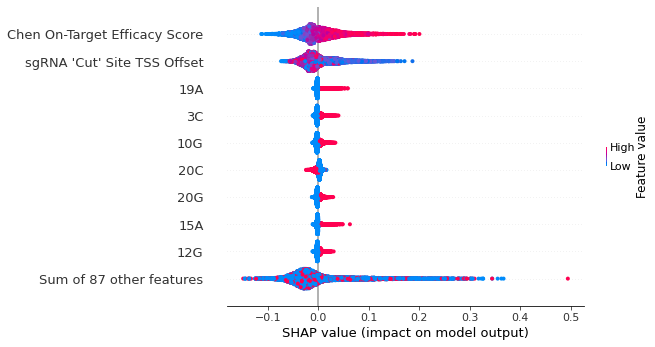

In [40]:
shap.plots.beeswarm(shap_values_model)


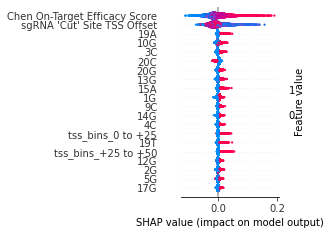

In [18]:
summary_legacy(shap_values_model, X, show=False, plot_size=(2.2, 3.5),
               point_size=5, text_size=None, color_bar_shrink=1,
               legend_aspect=50)
gpp.savefig('../figure/nts/shapval_model_seq_tss.pdf', dpi=300)

# Check the most optimal prediction using Gilbert

In [14]:
X_gilbert = X
y_gilbert = y

In [15]:
X_gilbert['Crispri Seq + Target Score'] = model.predict(X_gilbert)
X_gilbert.reset_index(inplace=True)

In [16]:
X_val_pre_y_gilbert = pd.merge(gilbert2014_rs3, X_gilbert, 
                               on = list(set(gilbert2014_rs3.columns) & set(X_gilbert.columns)))

In [17]:
#X_val_pre_y_gilbert['reverse gamma'] = X_val_pre_y_gilbert['avg_gamma']*-1

In [18]:
len(X_val_pre_y_gilbert['Target Gene Symbol'].value_counts()>10)

1259

In [19]:
gilbert2014_rs3_po = pd.read_csv('../data/gilbert_2014/gilbert2014_activity.csv')
gilbert2014_rs3_po.head()

,sgRNA Sequence,sgRNA Context Sequence,Target Gene Symbol,On-Target Efficacy Score,sgRNA 'Cut' Site TSS Offset,DHS Score,Off-Target Rank,Pick Order,avg_rank,avg_mean_centered_neg_gamma,avg_zscore_neg_gamma,avg_median_centered_neg_gamma,avg_robust_zscore_neg_gamma,avg_gamma
0,AAAAACCGTCAGTAACACCG,ACAGAAAAACCGTCAGTAACACCGAGGACA,DPH5,0.22540,281,1.0,14,26.0,0.800000,0.006335,0.231827,0.010429,0.469227,-0.023441
1,AAAAAGGAGGTGTCCGGGTA,GAGGAAAAAGGAGGTGTCCGGGTAGGGCAA,NAA15,-0.12330,121,0.0,38,53.0,0.200000,-0.032686,-0.502020,-0.012122,-0.330041,0.011355
2,AAAAATGGCAGCCGCCGCTC,GCAGAAAAATGGCAGCCGCCGCTCCGGACT,RRP15,0.03283,36,1.0,35,3.0,1.000000,0.054083,2.379131,0.059402,3.813684,-0.068108
3,AAAAGCCGCAGGTAGGAGCA,CTCGAAAAGCCGCAGGTAGGAGCAAGGATC,RPAP2,0.08538,93,0.0,72,12.0,0.300000,-0.212684,-0.886969,-0.093857,-0.217992,-0.001776
4,AAAAGGGGCGCGGTGAGCTA,CTGGAAAAGGGGCGCGGTGAGCTAGGGCGG,CSNK1A1,0.65740,155,0.0,19,36.0,0.555556,-0.016589,-0.397251,0.000000,0.000000,-0.007086


In [20]:
crispri_model = X_val_pre_y_gilbert[['Crispri Seq + Target Score','sgRNA Context Sequence']]

In [21]:
gilbert2014_rs3_po = pd.merge(gilbert2014_rs3_po, crispri_model, on = 'sgRNA Context Sequence')

In [22]:
gilbert2014_rs3_po

corr_crispri

,sgRNA Sequence,sgRNA Context Sequence,Target Gene Symbol,On-Target Efficacy Score,sgRNA 'Cut' Site TSS Offset,DHS Score,Off-Target Rank,Pick Order,avg_rank,avg_mean_centered_neg_gamma,avg_zscore_neg_gamma,avg_median_centered_neg_gamma,avg_robust_zscore_neg_gamma,avg_gamma,Crispri Seq + Target Score
0,AAAAACCGTCAGTAACACCG,ACAGAAAAACCGTCAGTAACACCGAGGACA,DPH5,0.22540,281,1.0,14,26.0,0.800000,0.006335,0.231827,0.010429,0.469227,-0.023441,0.028000
1,AAAAAGGAGGTGTCCGGGTA,GAGGAAAAAGGAGGTGTCCGGGTAGGGCAA,NAA15,-0.12330,121,0.0,38,53.0,0.200000,-0.032686,-0.502020,-0.012122,-0.330041,0.011355,-0.004270
2,AAAAATGGCAGCCGCCGCTC,GCAGAAAAATGGCAGCCGCCGCTCCGGACT,RRP15,0.03283,36,1.0,35,3.0,1.000000,0.054083,2.379131,0.059402,3.813684,-0.068108,0.066314
3,AAAAGCCGCAGGTAGGAGCA,CTCGAAAAGCCGCAGGTAGGAGCAAGGATC,RPAP2,0.08538,93,0.0,72,12.0,0.300000,-0.212684,-0.886969,-0.093857,-0.217992,-0.001776,0.002912
4,AAAAGGGGCGCGGTGAGCTA,CTGGAAAAGGGGCGCGGTGAGCTAGGGCGG,CSNK1A1,0.65740,155,0.0,19,36.0,0.555556,-0.016589,-0.397251,0.000000,0.000000,-0.007086,0.041160
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10596,TTTGGGGAGCGCTGGGGTTG,GGCGTTTGGGGAGCGCTGGGGTTGTGGTGG,TNPO1,-0.42880,139,1.0,55,58.0,0.900000,0.010758,1.017886,0.008721,0.625740,-0.015120,0.011580
10597,TTTGGTCCTTTCCGGGCGCG,GCGGTTTGGTCCTTTCCGGGCGCGCGGGGG,UPF1,-1.12300,170,1.0,14,62.0,0.500000,-0.003115,-0.255246,-0.000738,-0.071326,-0.000822,-0.007437
10598,TTTGGTGTTCCTGTGAACGT,GACGTTTGGTGTTCCTGTGAACGTGGGGCG,RIC8A,-0.06423,-32,0.0,11,38.0,0.666667,0.001184,0.106694,0.003264,0.398818,-0.004227,-0.008097
10599,TTTGTTTCCGGCGTGGGTCC,TGCGTTTGTTTCCGGCGTGGGTCCGGGCAA,CLP1,-0.41000,13,0.0,5,11.0,0.600000,-0.012396,-0.164703,0.006876,0.438869,-0.014314,0.033430


In [26]:
gene_corr_df = pd.DataFrame(columns=('gene', 'crispick', 'crispri'))
count = 0
for gene in gilbert2014_rs3_po['Target Gene Symbol'].to_list():
    s_gene_df = gilbert2014_rs3_po[gilbert2014_rs3_po['Target Gene Symbol'] == gene]
    if len(s_gene_df) > 9:
        corr_crispick, _ = stats.spearmanr(-1*s_gene_df['avg_gamma'], s_gene_df['Pick Order'])
        corr_crispri, _ = stats.spearmanr(s_gene_df['avg_gamma'], s_gene_df['Crispri Seq + Target Score'])
        gene_corr_df.loc[count] = [gene, corr_crispick, corr_crispri] 
        count += 1
        #dic_gene[gene] = corr_target
    else:
        continue

<AxesSubplot:xlabel='crispick', ylabel='crispri'>

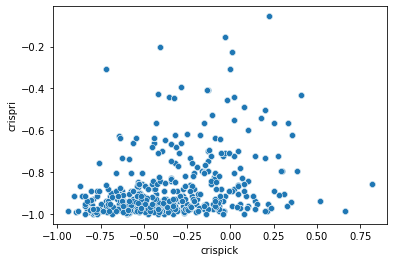

In [31]:
#gene_corr_df
sns.scatterplot(data = gene_corr_df, x = 'crispick', y = 'crispri')

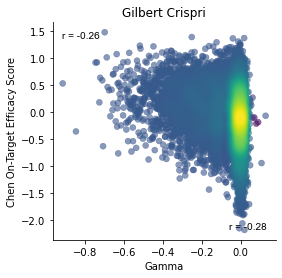

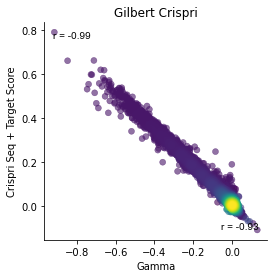

In [16]:
#obs_vals = [ 'avg_gamma', 'reverse gamma']
obs_vals = [ 'avg_gamma', 'avg_gamma']
scores = ['Chen On-Target Efficacy Score','Crispri Seq + Target Score']
obs_vals_vs_scores(X_val_pre_y_gilbert, obs_vals, scores, author='Gilbert', obs_meteric = 'Gamma')

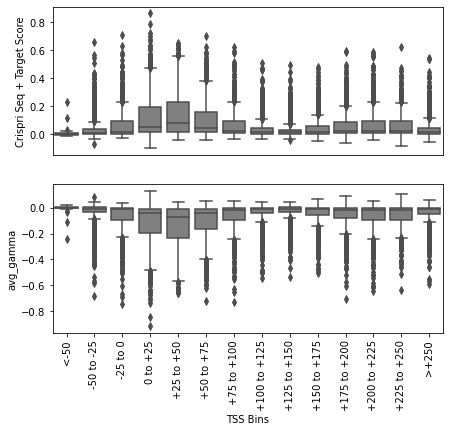

In [48]:
y_axis_gilbert = ["Crispri Seq + Target Score", 'avg_gamma']
tss_plot(X_val_pre_y_gilbert,y_axis_gilbert)

In [24]:
gilbert_performance = corr_pval_table(X_val_pre_y_gilbert, metric = 'gamma')

In [25]:
gilbert_performance

,bin,corr_rs3,p_val_corr_rs3,corr_seq_target,p_val_corr_seq_target
0,<-50,-0.356719,9.475101e-02,-0.694664,2.349586e-04
1,-50 to -25,-0.223628,8.775065e-10,-0.863417,5.299929e-220
2,-25 to 0,-0.236031,3.668072e-12,-0.898074,6.106768e-303
3,0 to +25,-0.268912,9.070488e-19,-0.956110,0.000000e+00
4,+25 to +50,-0.380375,4.365975e-32,-0.972689,0.000000e+00
5,+50 to +75,-0.377657,2.879616e-33,-0.964201,0.000000e+00
6,+75 to +100,-0.282004,1.275281e-16,-0.941656,0.000000e+00
7,+100 to +125,-0.252137,1.325435e-13,-0.907351,1.652849e-316
8,+125 to +150,-0.184255,6.874567e-08,-0.883067,3.050241e-279
9,+150 to +175,-0.255465,7.064837e-14,-0.904580,6.066697e-310


In [26]:
corr_gilbert = pd.melt(gilbert_performance, id_vars =['bin'], value_vars =['corr_rs3', 'corr_seq_target'])

Text(0, 0.5, 'Spearman Correlation')

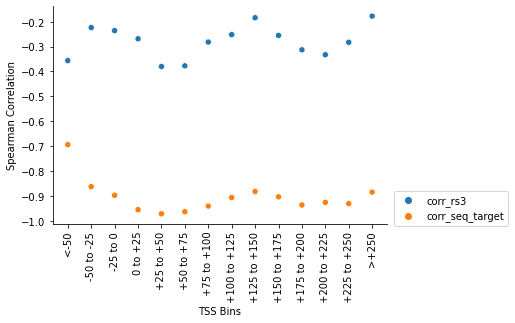

In [27]:
sns.scatterplot(data=corr_gilbert, x="bin", y="value", hue="variable")
sns.despine()
plt.legend(bbox_to_anchor=(1.02, 0.15), loc='upper left', borderaxespad=0)
plt.xticks(rotation=90)
plt.xlabel('TSS Bins')
plt.ylabel('Spearman Correlation')
#gpp.savefig('../figure/gilbert_spearman_tss_box_plot.pdf', dpi=300)


# Test on Horlbeck 2016_sept

In [32]:
test_dataset_horlbeck = pd.read_csv('../data/horlbeck_2016_sept/horlbeck2016_sept_activity.csv')


#### Add TSS bins binary

In [33]:
test_dataset_horlbeck = test_dataset_horlbeck.rename({'On-Target Efficacy Score': 'Chen On-Target Efficacy Score'},axis = 1)
test_dataset_horlbeck = tssbin_binary(test_dataset_horlbeck)

In [34]:
horlbeck_seq_feature = sglearn.featurize_guides(test_dataset_horlbeck['sgRNA Context Sequence'])
horlbeck_seq_feature = horlbeck_seq_feature.reset_index()
horlbeck_nts_feature = horlbeck_seq_feature[['sgRNA Context Sequence', '-4A', '-4C', '-4T', '-4G', '-3A', '-3C', '-3T', '-3G', '-2A',
       '-2C', '-2T', '-2G', '-1A', '-1C', '-1T', '-1G','1A', '1C', '1T', '1G', '2A', '2C', '2T', '2G', '3A', '3C', '3T', '3G', '4A', '4C',
       '4T', '4G', '5A', '5C', '5T', '5G', '6A', '6C', '6T', '6G', '7A',
       '7C', '7T', '7G', '8A', '8C', '8T', '8G', '9A', '9C', '9T', '9G',
       '10A', '10C', '10T', '10G', '11A', '11C', '11T', '11G', '12A',
       '12C', '12T', '12G', '13A', '13C', '13T', '13G', '14A', '14C',
       '14T', '14G', '15A', '15C', '15T', '15G', '16A', '16C', '16T',
       '16G', '17A', '17C', '17T', '17G', '18A', '18C', '18T', '18G',
       '19A', '19C', '19T', '19G', '20A', '20C', '20T', '20G']]


100%|██████████████████████████████████████| 3186/3186 [00:09<00:00, 342.67it/s]


#### Define X and Y 

In [35]:
test_dataset_horlbeck_X = test_dataset_horlbeck[x_variable]
test_dataset_horlbeck_X = pd.merge(test_dataset_horlbeck_X, horlbeck_nts_feature, on = 'sgRNA Context Sequence')
test_dataset_horlbeck_X = test_dataset_horlbeck_X.set_index('sgRNA Context Sequence')    
y = test_dataset_horlbeck['avg_lfc'] *-1

#### Predicted

In [36]:
test_dataset_horlbeck_X['Crispri Seq + Target Score'] = model.predict(test_dataset_horlbeck_X)
test_dataset_horlbeck_X.reset_index(inplace=True)

In [38]:
X_val_pre_y_horlbeck = pd.merge(test_dataset_horlbeck, test_dataset_horlbeck_X, 
                       on = list(set(test_dataset_horlbeck.columns) & set(test_dataset_horlbeck_X.columns)))

In [181]:
set(X_val_pre_y_horlbeck['Target Gene Symbol'].to_list())

{'SLU7',
 'DDX21',
 'RIC8A',
 'GFM1',
 'NUP43',
 'CDAN1',
 'CDC16',
 'DYNLRB1',
 'SHQ1',
 'RPP21',
 'CTU2',
 'BCAS2',
 'RIOK2',
 'SF3B2',
 'DDX6',
 'POLR2D',
 'MRPL20',
 'QRSL1',
 'URM1',
 'SLC7A6OS',
 'KIF2C',
 'RAD9A',
 'MRPS24',
 'AARS2',
 'LSG1',
 'SNUPN',
 'RNF40',
 'SEPSECS',
 'MCM6',
 'RCL1',
 'MRPL21',
 'OXSM',
 'TBCC',
 'YBEY',
 'SARS2',
 'AURKAIP1',
 'FAM50A',
 'HSCB',
 'COG2',
 'DCPS',
 'TINF2',
 'GTF3C2',
 'RFC2',
 'SUGT1',
 'CENPF',
 'SMC5',
 'RABGGTB',
 'PPIL4',
 'URI1',
 'DDX47',
 'ARFRP1',
 'POLRMT',
 'ALYREF',
 'NIP7',
 'C1orf131',
 'NEMF',
 'MRPL15',
 'BMS1',
 'EIF2B4',
 'UTP14A',
 'NRDE2',
 'COG8',
 'DYNC1H1',
 'DDX1',
 'PRPF40A',
 'NDUFA2',
 'ZNF574',
 'RICTOR',
 'FKBPL',
 'MRPS34',
 'WDR73',
 'MRPS15',
 'IPO7',
 'DMAP1',
 'PTCD3',
 'HNRNPU',
 'ATP6V1B2',
 'PPP2CA',
 'SON',
 'MDM2',
 'SYMPK',
 'TIGD3',
 'GPN3',
 'UTP23',
 'CCNH',
 'ATIC',
 'CRKL',
 'ZNHIT6',
 'CEP97',
 'NEDD1',
 'POLD2',
 'NELFA',
 'MRPS7',
 'GAR1',
 'SNRPD2',
 'UNC45A',
 'DHX33',
 'U2AF2',
 'DDX52'

In [182]:

gene_corr_df_horlbeck = pd.DataFrame(columns=('gene', 'crispick', 'crispri'))
count = 0
for gene in set(X_val_pre_y_horlbeck['Target Gene Symbol'].to_list()):
    s_gene_df = X_val_pre_y_horlbeck[X_val_pre_y_horlbeck['Target Gene Symbol'] == gene]
    if len(s_gene_df) > 4:
        corr_crispick, _ = stats.spearmanr(-1*s_gene_df['avg_lfc'], s_gene_df['Pick Order'])
        corr_crispri, _ = stats.spearmanr(s_gene_df['avg_lfc'], s_gene_df['Crispri Seq + Target Score'])
        gene_corr_df_horlbeck.loc[count] = [gene, corr_crispick, corr_crispri] 
        count += 1
    else:
        continue

In [183]:
#(-gene_corr_df_horlbeck['crispri']gene_corr_df_horlbeck['crispick']
gene_corr_df_horlbeck['diff'] = gene_corr_df_horlbeck['crispri']-gene_corr_df_horlbeck['crispick']


In [185]:
gene_corr_df_horlbeck

,gene,crispick,crispri,diff
0,DYNLRB1,-0.600000,-0.800000,-0.200000
1,SF3B2,-0.100000,-0.700000,-0.600000
2,SNUPN,-0.300000,-0.600000,-0.300000
3,RCL1,0.428571,0.085714,-0.342857
4,CENPF,-0.714286,-0.657143,0.057143
...,...,...,...,...
78,DHODH,0.200000,-0.314286,-0.514286
79,PSMB2,-0.500000,0.300000,0.800000
80,MYC,-0.100000,-0.700000,-0.600000
81,NARS2,0.900000,-0.800000,-1.700000


In [186]:
worst_horlbeck = gene_corr_df_horlbeck[gene_corr_df_horlbeck['diff']>0]
worst_horlbeck['CRISPick pick order vs CRISPRi seq + target'] = 'CRISPick pick order is better than CRISPRi seq + target n = ' + str(len(worst_horlbeck))
equal_horlbeck = gene_corr_df_horlbeck[gene_corr_df_horlbeck['diff']==0]
equal_horlbeck['CRISPick pick order vs CRISPRi seq + target'] = 'Same n = ' + str(len(equal_horlbeck))

better_horlbeck = gene_corr_df_horlbeck[gene_corr_df_horlbeck['diff']<0]
better_horlbeck['CRISPick pick order vs CRISPRi seq + target'] = 'CRISPick pick order is worst than CRISPRi seq + target n = ' + str(len(better_horlbeck))


In [187]:
gene_corr_df_horlbeck = pd.concat([worst_horlbeck,equal_horlbeck,better_horlbeck])

In [188]:
equal_horlbeck.crispick.value_counts()

 0.6    1
 0.8    1
-0.7    1
-0.9    1
-0.5    1
 0.9    1
-0.3    1
-0.1    1
Name: crispick, dtype: int64

In [189]:
gene_corr_df_horlbeck['CRISPick pick order vs CRISPRi seq + target'].value_counts()

CRISPick pick order is worst than CRISPRi seq + target n = 50     50
CRISPick pick order is better than CRISPRi seq + target n = 25    25
Same n = 8                                                         8
Name: CRISPick pick order vs CRISPRi seq + target, dtype: int64

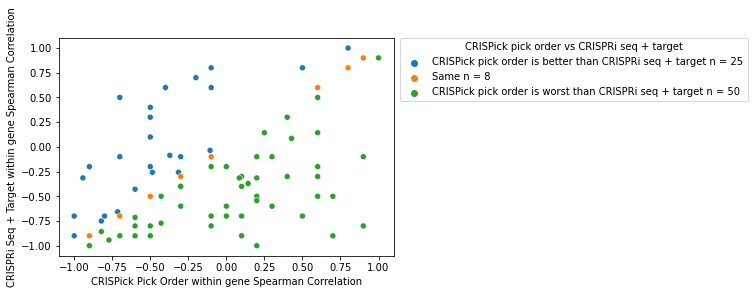

In [190]:
ax = sns.scatterplot(data = gene_corr_df_horlbeck, x = 'crispick', y = 'crispri', 
                hue = 'CRISPick pick order vs CRISPRi seq + target')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, title='CRISPick pick order vs CRISPRi seq + target')
ax.set_xlabel("CRISPick Pick Order within gene Spearman Correlation")
ax.set_ylabel("CRISPRi Seq + Target within gene Spearman Correlation")
gpp.savefig('../figure/nts/'+ 'horlbeck' +'_crispick_crispri_scatterplot.pdf', dpi=300)


In [191]:
#sns.boxplot(gene_corr_df_horlbeck, x = 'diff')

boxplot_horlbeck = pd.melt(gene_corr_df_horlbeck, id_vars =['gene'], value_vars =['crispick', 'crispri', 'diff'])

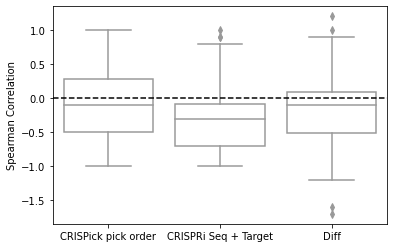

In [192]:
ax = sns.boxplot(data=boxplot_horlbeck, x="variable", y="value", color='white')
plt.axhline(y=0, color='black', linestyle='--')
ax.set_xlabel("")
ax.set_ylabel("Spearman Correlation")
ax.set_xticklabels(["CRISPick pick order","CRISPRi Seq + Target",'Diff'])
gpp.savefig('../figure/nts/'+ 'horlbeck' +'_crispick_crispri_boxplot.pdf', dpi=300)


In [193]:
import pandas as pd
import researchpy as rp
import scipy.stats as stats
rp.ttest(group1= gene_corr_df_horlbeck['crispick'], group1_name= "crispick",
         group2= gene_corr_df_horlbeck['crispri'], group2_name= "crispri")

(   Variable      N      Mean        SD        SE  95% Conf.  Interval
 0  crispick   83.0 -0.096386  0.538382  0.059095  -0.213944  0.021173
 1   crispri   83.0 -0.276420  0.529992  0.058174  -0.392147 -0.160693
 2  combined  166.0 -0.186403  0.540182  0.041926  -0.269184 -0.103622,
                    Independent t-test   results
 0  Difference (crispick - crispri) =     0.1800
 1               Degrees of freedom =   164.0000
 2                                t =     2.1711
 3            Two side test p value =     0.0314
 4           Difference < 0 p value =     0.9843
 5           Difference > 0 p value =     0.0157
 6                        Cohen's d =     0.3370
 7                        Hedge's g =     0.3355
 8                    Glass's delta =     0.3344
 9                      Pearson's r =     0.1671)

In [34]:
#X_val_pre_y_horlbeck['reverse lfc'] = X_val_pre_y_horlbeck['avg_lfc']*-1

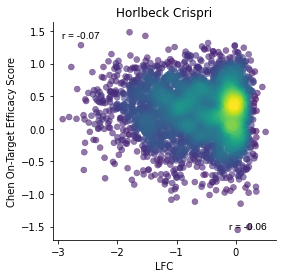

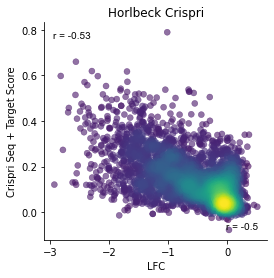

In [35]:
#obs_vals_h = [ 'avg_lfc', 'reverse lfc']
obs_vals_h = [ 'avg_lfc', 'avg_lfc']

scores = ['Chen On-Target Efficacy Score','Crispri Seq + Target Score']
obs_vals_vs_scores(X_val_pre_y_horlbeck, obs_vals_h, scores, author='Horlbeck', obs_meteric = 'LFC')

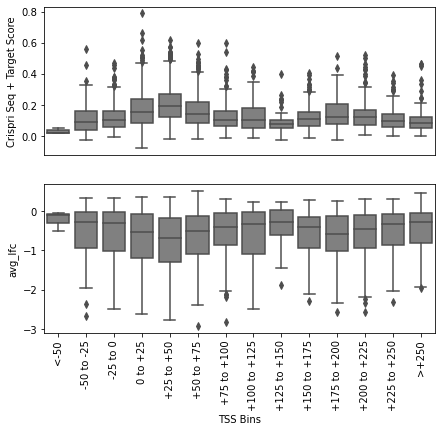

In [36]:
y_axis_horlbeck = ["Crispri Seq + Target Score", 'avg_lfc']
tss_plot(X_val_pre_y_horlbeck,y_axis_horlbeck, dataname='horlbeck')

In [37]:
horlbeck_performance = corr_pval_table(X_val_pre_y_horlbeck, metric = 'lfc')
corr_horlbeck = pd.melt(horlbeck_performance, id_vars =['bin'], value_vars =['corr_rs3', 'corr_seq_target'])

In [38]:
X_val_pre_y_horlbeck['tss_bins'].value_counts()

+25 to +50      645
0 to +25        599
+50 to +75      499
-25 to 0        285
+75 to +100     209
+200 to +225    178
+225 to +250    171
>+250           153
+175 to +200    126
-50 to -25       94
+150 to +175     91
+100 to +125     83
+125 to +150     50
<-50              3
Name: tss_bins, dtype: int64

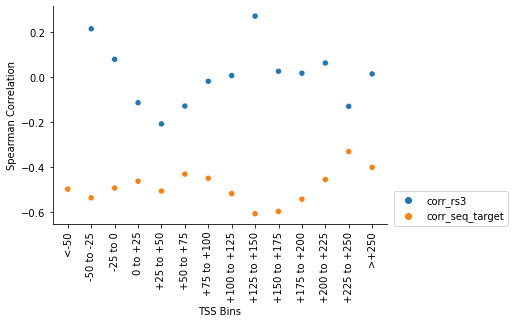

In [39]:
sns.scatterplot(data=corr_horlbeck, x="bin", y="value", hue="variable")
sns.despine()
plt.legend(bbox_to_anchor=(1.02, 0.15), loc='upper left', borderaxespad=0)
plt.xticks(rotation=90)
plt.xlabel('TSS Bins')
plt.ylabel('Spearman Correlation')
gpp.savefig('../figure/nts/horlbeck_spearman_tss_box_plot.pdf', dpi=300)


# Sanson et al

In [123]:
test_dataset_sanson = pd.read_csv('../data/sanson_2018/sanson2018_activity.csv')


In [124]:
test_dataset_sanson = test_dataset_sanson.rename({'On-Target Efficacy Score': 'Chen On-Target Efficacy Score'},axis = 1)
test_dataset_sanson= tssbin_binary(test_dataset_sanson)

In [125]:
sum(test_dataset_sanson['sgRNA \'Cut\' Site TSS Offset'] <= -50)

0

In [126]:
sanson_seq_feature = sglearn.featurize_guides(test_dataset_sanson['sgRNA Context Sequence'])
sanson_seq_feature = sanson_seq_feature.reset_index()
sanson_nts_feature = sanson_seq_feature[['sgRNA Context Sequence', '-4A', '-4C', '-4T', '-4G', '-3A', '-3C', '-3T', '-3G', '-2A',
       '-2C', '-2T', '-2G', '-1A', '-1C', '-1T', '-1G','1A', '1C', '1T', '1G', '2A', '2C', '2T', '2G', '3A', '3C', '3T', '3G', '4A', '4C',
       '4T', '4G', '5A', '5C', '5T', '5G', '6A', '6C', '6T', '6G', '7A',
       '7C', '7T', '7G', '8A', '8C', '8T', '8G', '9A', '9C', '9T', '9G',
       '10A', '10C', '10T', '10G', '11A', '11C', '11T', '11G', '12A',
       '12C', '12T', '12G', '13A', '13C', '13T', '13G', '14A', '14C',
       '14T', '14G', '15A', '15C', '15T', '15G', '16A', '16C', '16T',
       '16G', '17A', '17C', '17T', '17G', '18A', '18C', '18T', '18G',
       '19A', '19C', '19T', '19G', '20A', '20C', '20T', '20G']]

100%|██████████████████████████████████████| 4337/4337 [00:12<00:00, 346.39it/s]


In [127]:
test_dataset_sanson['tss_bins_<-50'] = 0

In [128]:
test_dataset_sanson_X = test_dataset_sanson[x_variable]
test_dataset_sanson_X = pd.merge(test_dataset_sanson_X, sanson_nts_feature, on = 'sgRNA Context Sequence')

test_dataset_sanson_X = test_dataset_sanson_X.set_index('sgRNA Context Sequence')    
y = test_dataset_sanson['avg_lfc']*-1


In [129]:
test_dataset_sanson_X['Crispri Seq + Target Score'] = model.predict(test_dataset_sanson_X)
test_dataset_sanson_X.reset_index(inplace=True)

In [130]:
X_val_pre_y_sanson = pd.merge(test_dataset_sanson, test_dataset_sanson_X, 
                              on = list(set(test_dataset_sanson.columns) & set(test_dataset_sanson_X.columns)))

In [131]:
#X_val_pre_y_sanson['reverse lfc'] = X_val_pre_y_sanson['avg_lfc']*-1

In [132]:
X_val_pre_y_sanson.tss_bins.value_counts()

+50 to +75      1968
+25 to +50      1951
0 to +25         256
+75 to +100       47
+200 to +225      35
+225 to +250      33
+175 to +200      14
>+250              8
-25 to 0           7
+150 to +175       6
+100 to +125       5
+125 to +150       4
-50 to -25         3
Name: tss_bins, dtype: int64

In [198]:
gene_corr_df_sanson = pd.DataFrame(columns=('gene', 'crispick', 'crispri'))
count = 0
for gene in set(X_val_pre_y_sanson['Target Gene Symbol'].to_list()):
    s_gene_df = X_val_pre_y_sanson[X_val_pre_y_sanson['Target Gene Symbol'] == gene]
    if len(s_gene_df) > 4:
        corr_crispick, _ = stats.spearmanr(-1*s_gene_df['avg_lfc'], s_gene_df['Pick Order'])
        corr_crispri, _ = stats.spearmanr(s_gene_df['avg_lfc'], s_gene_df['Crispri Seq + Target Score'])
        gene_corr_df_sanson.loc[count] = [gene, corr_crispick, corr_crispri] 
        count += 1
    else:
        continue

In [195]:
len(gene_corr_df_sanson)

1408

In [197]:
len(gene_corr_df_sanson)

6

In [199]:
len(gene_corr_df_sanson)

5

In [174]:
len(X_val_pre_y_sanson['Target Gene Symbol'].to_list())

4337

In [167]:
gene_corr_df_sanson
gene_corr_df_sanson['diff'] = gene_corr_df_sanson['crispri']-gene_corr_df_sanson['crispick']


In [171]:
X_val_pre_y_sanson['Target Gene Symbol'].value_counts()

RPP38       6
SRCAP       6
SEC16A      6
U2AF1       6
MED14       6
           ..
LENG1       1
SLC7A6OS    1
TWNK        1
INTS7       1
PTPMT1      1
Name: Target Gene Symbol, Length: 1461, dtype: int64

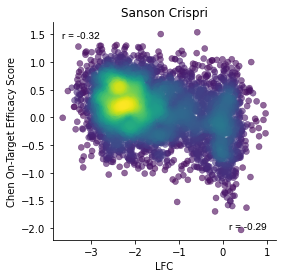

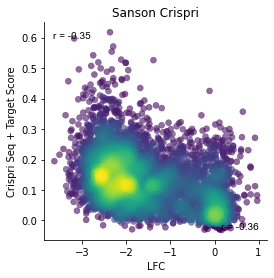

In [49]:
#obs_vals_h = [ 'avg_lfc', 'reverse lfc']
obs_vals_h = [ 'avg_lfc', 'avg_lfc']

scores = ['Chen On-Target Efficacy Score','Crispri Seq + Target Score']
obs_vals_vs_scores(X_val_pre_y_sanson, obs_vals_h, scores, author='Sanson', obs_meteric = 'LFC')

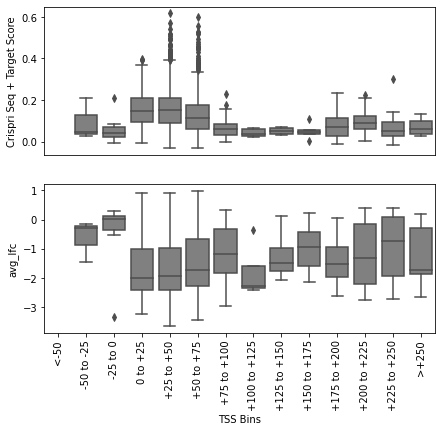

In [50]:
y_axis_sanson = ["Crispri Seq + Target Score", 'avg_lfc']
tss_plot(X_val_pre_y_sanson,y_axis_sanson, dataname = 'sanson')

In [51]:
sanson_performance = corr_pval_table(X_val_pre_y_sanson, metric = 'lfc')
corr_sanson = pd.melt(sanson_performance, id_vars =['bin'], value_vars =['corr_rs3', 'corr_seq_target'])

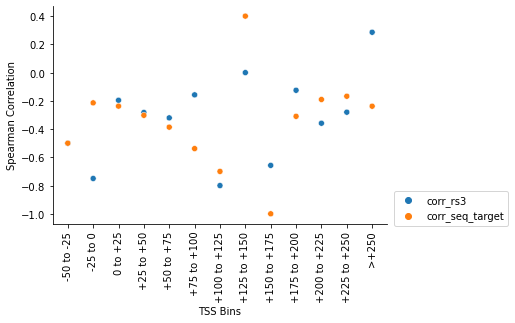

In [52]:
sns.scatterplot(data=corr_sanson, x="bin", y="value", hue="variable")
sns.despine()
plt.legend(bbox_to_anchor=(1.02, 0.15), loc='upper left', borderaxespad=0)
plt.xticks(rotation=90)
plt.xlabel('TSS Bins')
plt.ylabel('Spearman Correlation')
gpp.savefig('../figure/nts/sanson_spearman_tss_box_plot.pdf', dpi=300)


In [64]:
# anaysis

In [116]:
gene_symbol = pd.DataFrame(X_val_pre_y_sanson['Target Gene Symbol'].value_counts()).reset_index()
gene_symbol = gene_symbol[gene_symbol['Target Gene Symbol'] >= 3]
gene_3 = X_val_pre_y_sanson[X_val_pre_y_sanson['Target Gene Symbol'].isin(gene_symbol['index'])]

In [117]:
gene_corr_rs3 = gene_3.groupby('Target Gene Symbol')[['avg_lfc','Chen On-Target Efficacy Score']].corr(method = 'spearman').unstack()
gene_corr_rs3.columns = ['Correlation_Val1_Val1', 'Correlation_LFC_RS3', 'Correlation_Val2_Val1', 'Correlation_Val2_Val2']
gene_corr_rs3 = pd.DataFrame(gene_corr_rs3.iloc[:,1]).reset_index()

In [118]:
gene_corr_rs3_target = gene_3.groupby('Target Gene Symbol')[['avg_lfc','Crispri Seq + Target Score']].corr(method = 'spearman').unstack()
gene_corr_rs3_target.columns = ['Correlation_Val1_Val1', 'Correlation_LFC_RS3_target', 'Correlation_Val2_Val1', 'Correlation_Val2_Val2']
gene_corr_rs3_target = pd.DataFrame(gene_corr_rs3_target.iloc[:,1]).reset_index()

In [119]:
gene_corr_scores = gene_3.groupby('Target Gene Symbol')[['Chen On-Target Efficacy Score','Crispri Seq + Target Score']].corr(method = 'spearman').unstack()
gene_corr_scores.columns = ['Correlation_Val1_Val1', 'Correlation_RS3_target', 'Correlation_Val2_Val1', 'Correlation_Val2_Val2']
gene_corr_scores = pd.DataFrame(gene_corr_scores.iloc[:,1]).reset_index()


In [120]:
gene_corr = pd.merge(pd.merge(gene_corr_rs3, gene_corr_rs3_target, on = 'Target Gene Symbol'), gene_corr_scores, on = 'Target Gene Symbol')

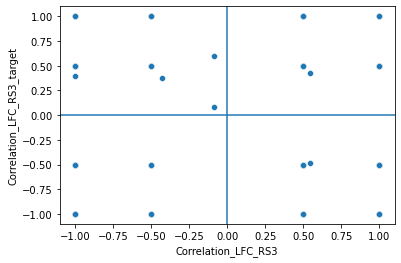

In [127]:
sns.scatterplot(data=gene_corr, x="Correlation_LFC_RS3", y="Correlation_LFC_RS3_target")
plt.axvline(0, 0,2)
plt.axhline(0, 0,2)

<AxesSubplot:xlabel='Correlation_RS3_target'>

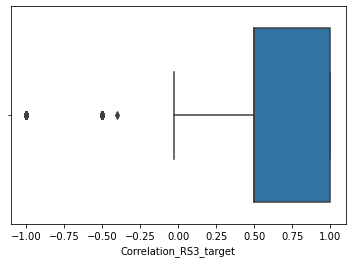

In [122]:
sns.boxplot(x=gene_corr["Correlation_RS3_target"] )

In [136]:
gene_corr[(gene_corr['Correlation_LFC_RS3'] < 0) & (gene_corr['Correlation_LFC_RS3_target']>0)]

,Target Gene Symbol,Correlation_LFC_RS3,Correlation_LFC_RS3_target,Correlation_RS3_target
1,AARS1,-0.5,0.5,0.5
5,ABCB7,-0.5,0.5,0.5
13,ACTR10,-0.5,0.5,-1.0
14,ACTR1A,-0.5,0.5,-1.0
23,ALDOA,-0.5,0.5,0.5
...,...,...,...,...
1391,ZBTB11,-1.0,0.5,-0.5
1392,ZBTB17,-0.5,0.5,0.5
1393,ZC3H18,-0.5,0.5,0.5
1403,ZNF408,-1.0,0.5,-0.5
